In [1]:
import os
import numpy as np
import time
import pickle
import imp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt


from cruw import CRUW
from rodnet.datasets.CRDataset import CRDataset
from rodnet.datasets.collate_functions import cr_collate
from rodnet.utils.solve_dir import create_dir_for_new_model
from rodnet.utils.load_configs import load_configs_from_file, parse_cfgs, update_config_dict
from rodnet.utils.visualization import visualize_train_img, visualize_test_img_wo_gt, visualize_confmap, visualize_test_img
from rodnet.core.post_processing import ConfmapStack, post_process, post_process_single_frame, write_dets_results, write_dets_results_single_frame, lnms, ops

/var/folders/lj/_chmmmhd2m5328svknqdk8b80000gn/T/ipykernel_18796/670376179.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<Figure size 800x800 with 0 Axes>

In [2]:
config_dict = load_configs_from_file('/Users/kushalgadhiya/Desktop/Winter2024/ENDG 511/Project/RODNet-master/configs/config_rodnet_cdc_win16.py')
dataset = CRUW(data_root=config_dict['dataset_cfg']['base_root'], sensor_config_name='sensor_config_rod2021')
radar_configs = dataset.sensor_cfg.radar_cfg
range_grid = dataset.range_grid         
angle_grid = dataset.angle_grid         
model_cfg = config_dict['model_cfg']

In [3]:
crdata_train = CRDataset(data_dir='/Volumes/T7MAC/data_v3', dataset=dataset, config_dict=config_dict, split='train',
                                 noise_channel= False)
print(len(crdata_train))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

3058


In [4]:
n_class = dataset.object_cfg.n_class          
n_epoch = config_dict['train_cfg']['n_epoch']   
batch_size = config_dict['train_cfg']['batch_size'] 
lr = config_dict['train_cfg']['lr']
train_configs = config_dict['train_cfg']
test_configs = config_dict['test_cfg']
win_size = train_configs['win_size']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
testdata, valdata = torch.utils.data.random_split(crdata_train,[3048,10])

In [6]:
tdataloader = DataLoader(testdata, batch_size, shuffle=True, num_workers=0, collate_fn=cr_collate)
vdataloader = DataLoader(valdata, batch_size =1, shuffle=True, num_workers=0, collate_fn=cr_collate)

In [7]:
train_model_path = '/Volumes/T7MAC/trainedrepo'         #entre your desired location to store trained model
if not os.path.exists(train_model_path):
    os.makedirs(train_model_path)
test_res_dir_base = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'base'))
if not os.path.exists(test_res_dir_base):
    os.makedirs(test_res_dir_base)
test_res_dir_multi = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'multi'))
if not os.path.exists(test_res_dir_multi):
    os.makedirs(test_res_dir_multi)

In [8]:
import getModel
imp.reload(getModel)
from getModel import ROD_V0, ROD_V1
import trainModel
imp.reload(trainModel)
from trainModel import modelHandler,baseHandler

In [9]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
optimizer_v0 = optim.Adam(rod_v0.parameters(), lr=lr)
criterion_v0 = nn.BCELoss()
scheduler_v0 = StepLR(optimizer_v0, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v0 = baseHandler(rod_v0,criterion_v0,optimizer_v0,device,scheduler_v0,n_epoch)

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174


In [10]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
optimizer_v1 = optim.Adam(rod_v1.parameters(), lr=lr)
criterion_v1 = nn.BCELoss()
scheduler_v1 = StepLR(optimizer_v1, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v1 = modelHandler(rod_v1,criterion_v1,optimizer_v1,device,scheduler_v1,n_epoch)

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110


***Train base Model***

epoch 1 --> trainLoss: 0.001
saving current epoch model ...
epoch 2 --> trainLoss: 0.001
saving current epoch model ...
epoch 3 --> trainLoss: 0.001
saving current epoch model ...


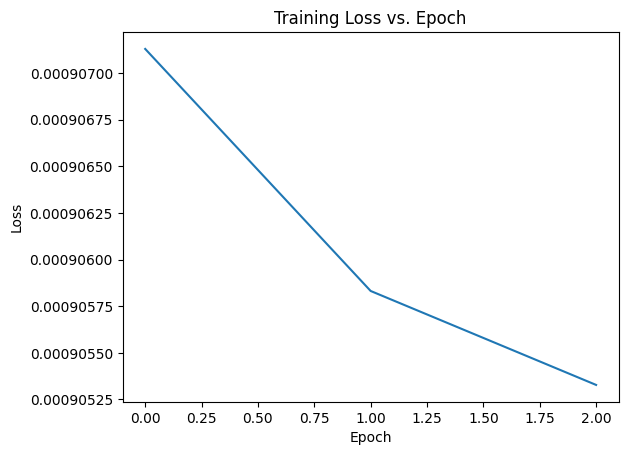

In [11]:
rodNet_v0, history_v0 = M_v0.train(tdataloader,train_model_path)
total_loss = history_v0['train']['loss']
epochs = np.array([i for i in range(3)])
plt.plot(epochs, total_loss)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

***Train multibranch model***

epoch 1 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 2 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 3 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...


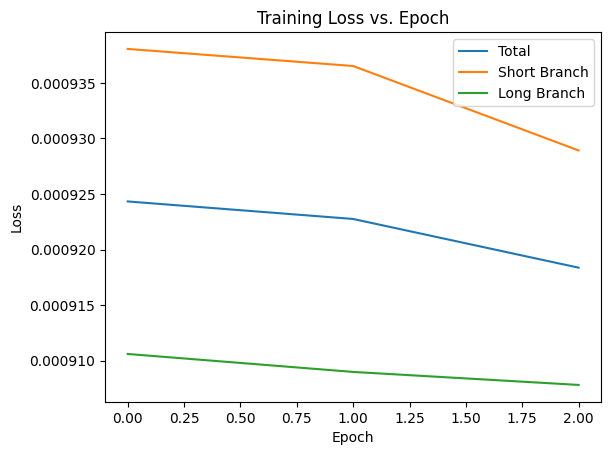

In [12]:
rodNet_v1, history_v1 = M_v1.train(tdataloader,train_model_path)
total_loss = history_v1['T']['train']['loss']
short_branch_loss = history_v1['1']['train']['loss']
long_branch_loss = history_v1['2']['train']['loss']
epochs = np.array([i for i in range(3)])
plt.plot(epochs, total_loss, label='Total')
plt.plot(epochs,short_branch_loss, label='Short Branch')
plt.plot(epochs,long_branch_loss, label='Long Branch')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from cruw.eval import evaluate_rodnet_seq
from cruw.eval.rod.rod_eval_utils import accumulate, summarize
from cruw.eval.rod.load_txt import read_gt_txt, read_sub_txt, read_rodnet_res
from cruw.eval.rod.rod_eval_utils import compute_ols_dts_gts, evaluate_img, accumulate, summarize

In [14]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
rod_v0.load_state_dict(torch.load(os.path.join(train_model_path,'base_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v0.eval()
validation_loss_class_0 = []
validation_loss_class_1 = []
validation_loss_class_2 = []
ols_ans = []
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_pred = rod_v0(data.float())
        loss_class_0 = criterion_v0(confmap_pred[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()).item()
        loss_class_1 = criterion_v0(confmap_pred[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()).item()
        loss_class_2 = criterion_v0(confmap_pred[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()).item()
        validation_loss_class_0.append(loss_class_0)
        validation_loss_class_1.append(loss_class_1)
        validation_loss_class_2.append(loss_class_2)
        pred = confmap_pred[0,:,0,:,:]

        #print(seq_name)
        result = post_process_single_frame(pred, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_base, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f = open(os.path.join(seq_res_dir, 'rod_res.txt'), 'a')
        f.close()
        save_path = os.path.join(test_res_dir_base, seq_name, 'rod_res.txt')

        write_dets_results_single_frame(result, start_frame, save_path, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        sub_dets = read_rodnet_res(save_path, n_frame, dataset)
        olss_all = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans.append(olss_all)
   

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174
2019_05_29_BCMS000
2019_04_09_PMS1000
2019_04_30_MLMS000
2019_05_09_CM1S004
2019_05_29_PBMS007
2019_05_09_CM1S004
2019_04_30_PCMS001
2019_05_29_PBMS007
2019_04_30_PBMS002
2019_05_29_BCMS000


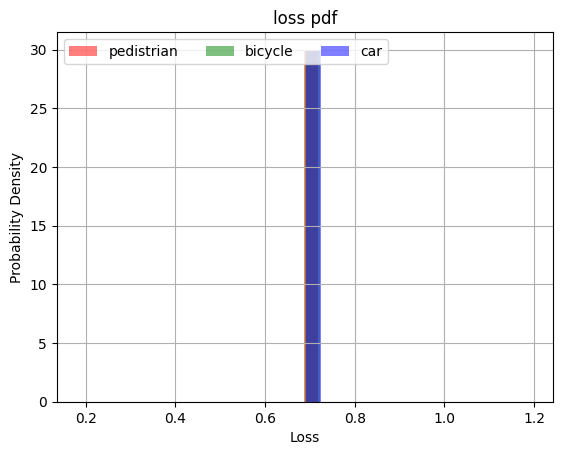

In [15]:
plt.hist(np.round(np.array(validation_loss_class_0),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(validation_loss_class_1),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(validation_loss_class_2),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()

In [17]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
rod_v1.load_state_dict(torch.load(os.path.join(train_model_path,'multi_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v1.eval()
val_loss_class_0_short = []
val_loss_class_1_short = []
val_loss_class_2_short = []
val_loss_class_0_long = []
val_loss_class_1_long = []
val_loss_class_2_long = []
early_exit_count = 0
ols_ans_1 = []
ols_ans_2 = []
early_exit_count = 0
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_preds_1,confmap_preds_2 = rod_v1(data.float())
        loss_1_class0, loss_2_class0 = criterion_v1(confmap_preds_1[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()), criterion_v1(confmap_preds_2[:,0,:,:,:], confmap_gt[:,0,:,:,:].float())
        loss_1_class1, loss_2_class1 = criterion_v1(confmap_preds_1[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()), criterion_v1(confmap_preds_2[:,1,:,:,:], confmap_gt[:,1,:,:,:].float())
        loss_1_class2, loss_2_class2 = criterion_v1(confmap_preds_1[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()), criterion_v1(confmap_preds_2[:,2,:,:,:], confmap_gt[:,2,:,:,:].float())
        val_loss_class_0_short.append(loss_1_class0)
        val_loss_class_1_short.append(loss_1_class1)
        val_loss_class_2_short.append(loss_1_class2)
        val_loss_class_0_long.append(loss_2_class0)
        val_loss_class_1_long.append(loss_2_class1)
        val_loss_class_2_long.append(loss_2_class2)

        pred1 = confmap_preds_1[0,:,0,:,:]
        pred2 = confmap_preds_2[0,:,0,:,:]

        #print(seq_name)
        result1 = post_process_single_frame(pred1, dataset, config_dict)
        result2 = post_process_single_frame(pred2, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_multi, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f1 = open(os.path.join(seq_res_dir, 'rod_res_1.txt'), 'a')
        f2 = open(os.path.join(seq_res_dir, 'rod_res_2.txt'), 'a')
        f1.close()
        f2.close()
        save_path_1 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_1.txt')
        save_path_2 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_2.txt')

        write_dets_results_single_frame(result1, start_frame, save_path_1, dataset)
        write_dets_results_single_frame(result2, start_frame, save_path_2, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        sub_dets_1 = read_rodnet_res(save_path_1, n_frame, dataset)
        sub_dets_2 = read_rodnet_res(save_path_2, n_frame, dataset)
        olss_all_1 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_1, start_frame, catId, dataset) \
                    for catId in range(3)}
        olss_all_2 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_2, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans_1.append(olss_all_1)
        ols_ans_1.append(olss_all_2)
        
        if(len(gt_dets[start_frame,0]) == len(sub_dets_1[start_frame,0]) and len(gt_dets[start_frame,1]) == len(sub_dets_1[start_frame,1]) and len(gt_dets[start_frame,2]) == len(sub_dets_1[start_frame,2])):
            early_exit_count += 1
        
    print("Number of samples will exit early {}".format(early_exit_count))
        # print('ground_truth')
        # print(gt_dets[start_frame,0])
        # print(gt_dets[start_frame,1])
        # print(gt_dets[start_frame,2])
        # print('predicted 1')
        # print(sub_dets_1[start_frame,0])
        # print(sub_dets_1[start_frame,1])
        # print(sub_dets_1[start_frame,2])
        # print('predicted 2')
        # print(sub_dets_2[start_frame,0])
        # print(sub_dets_2[start_frame,1])
        # print(sub_dets_2[start_frame,2])
        # print(olss_all)

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110
0


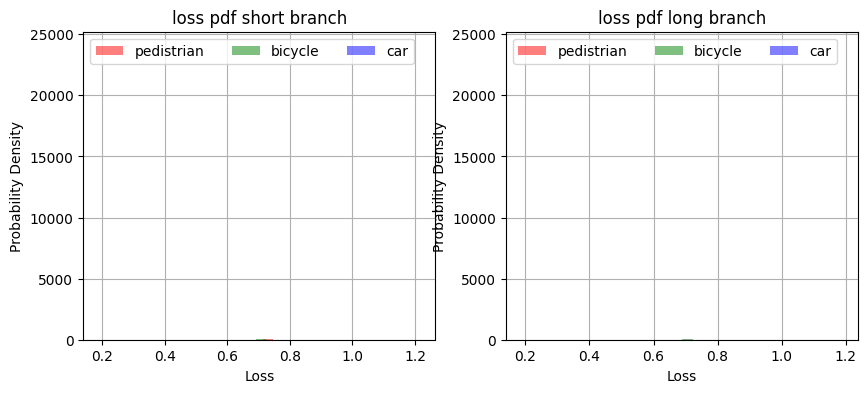

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(np.round(np.array(val_loss_class_0_short),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_short),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_short),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf short branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(np.round(np.array(val_loss_class_0_long),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_long),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_long),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf long branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()